In [8]:
# --- Core libs
import pandas as pd
import numpy as np

# --- Viz
import seaborn as sns
import matplotlib.pyplot as plt

# --- File utilities
import glob

# Ensure nice, sharp plots
%matplotlib inline

# Set a single Seaborn theme for all plots
sns.set_theme(style="whitegrid", context="talk", palette="deep")

# Paths
MERGED_PATH = "citibike_weather_2022.csv"   # daily merged dataset
RAW_CSV_GLOB = "extracted/csvs/*.csv"       # raw trips to read only station names

# Read the merged daily dataset (weather + trip counts)
df = pd.read_csv(MERGED_PATH, parse_dates=["date"])
df = df.sort_values("date").reset_index(drop=True)

# Quick sanity check
display(df.head())
display(df.columns)


,date,trips,member_trips,casual_trips,mean_duration_min,TMAX,TMIN,PRCP,SNOW,AWND
0,2021-01-30,1,0,1,687646.693117,NaN,NaN,NaN,NaN,NaN
1,2021-02-15,1,0,1,779090.164883,NaN,NaN,NaN,NaN,NaN
2,2021-03-11,1,0,1,664503.451733,NaN,NaN,NaN,NaN,NaN
3,2021-03-14,1,1,0,468320.034500,NaN,NaN,NaN,NaN,NaN
4,2021-03-31,1,0,1,781858.025617,NaN,NaN,NaN,NaN,NaN


Index(['date', 'trips', 'member_trips', 'casual_trips', 'mean_duration_min',
       'TMAX', 'TMIN', 'PRCP', 'SNOW', 'AWND'],
      dtype='object')

## Top 20 starting stations (bar chart)

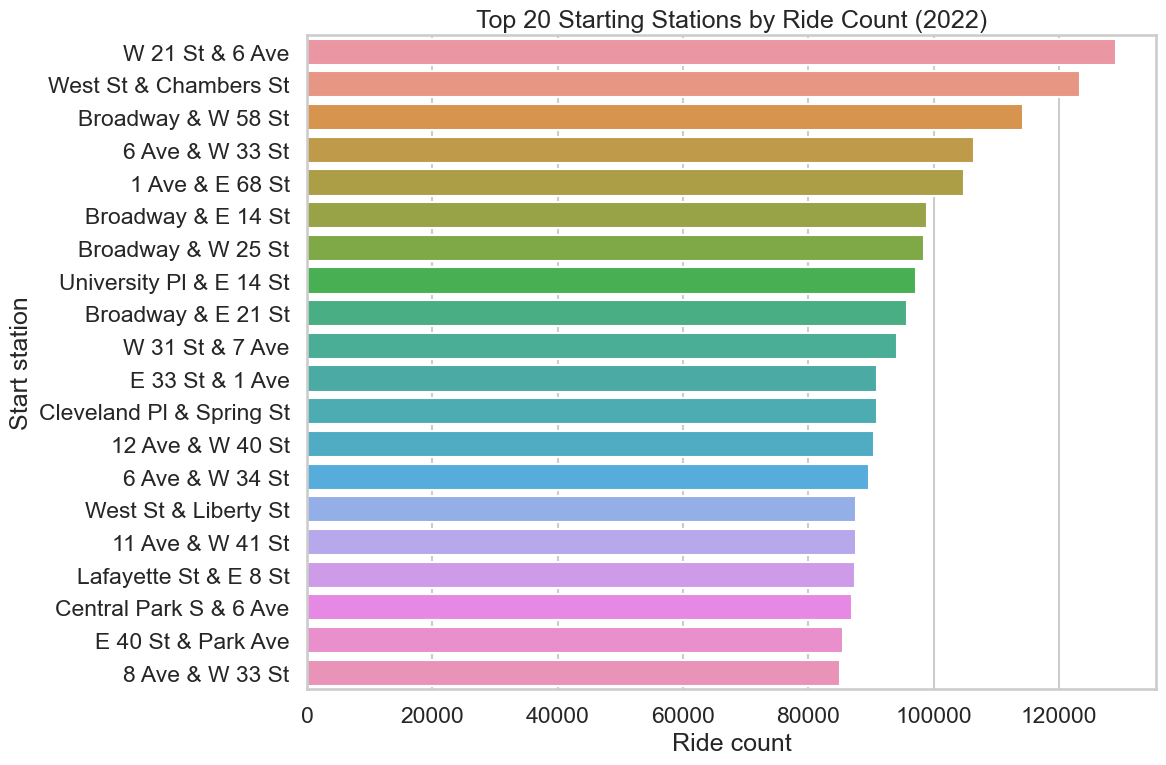

In [11]:
# Collect all unzipped monthly CSVs
trip_files = sorted(glob.glob(RAW_CSV_GLOB))
assert len(trip_files) > 0, "No CSVs found under extracted/csvs/*.csv"

# Load just the start_station_name column from each file
station_chunks = []
for f in trip_files:
    try:
        s = pd.read_csv(f, usecols=["start_station_name"])
        station_chunks.append(s)
    except ValueError:
        # Fallback for the occasional file that may use a slightly different header name
        cols = pd.read_csv(f, nrows=0).columns.str.lower()
        alt_col = [c for c in cols if "start_station" in c and "name" in c]
        if alt_col:
            s = pd.read_csv(f, usecols=[alt_col[0]])
            s.columns = ["start_station_name"]
            station_chunks.append(s)
        else:
            print(f"Skipped (couldn't find station name): {f}")

stations = pd.concat(station_chunks, ignore_index=True)

# Count frequencies, take top 20
top20 = (stations["start_station_name"]
         .value_counts()
         .head(20)
         .rename_axis("start_station_name")
         .reset_index(name="rides"))

# Bar chart (horizontal)
plt.figure(figsize=(12, 8))
sns.barplot(data=top20, x="rides", y="start_station_name")
plt.title("Top 20 Starting Stations by Ride Count (2022)")
plt.xlabel("Ride count")
plt.ylabel("Start station")
plt.tight_layout()
plt.show()


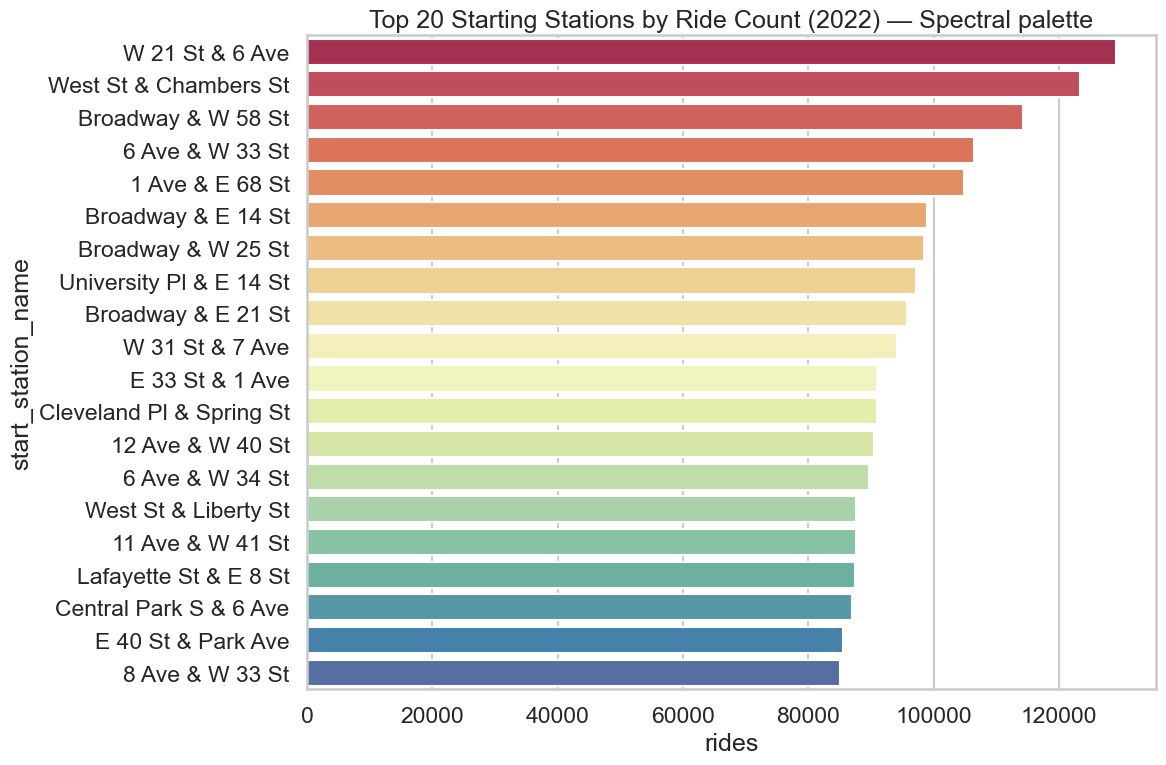

In [13]:
plt.figure(figsize=(12, 8))
sns.barplot(
    data=top20, x="rides", y="start_station_name",
    palette=sns.color_palette("Spectral", n_colors=len(top20))
)
plt.title("Top 20 Starting Stations by Ride Count (2022) — Spectral palette")
plt.tight_layout()
plt.show()


## Recreate the dual-axis seasonality line plot (trips & temperature) with Seaborn

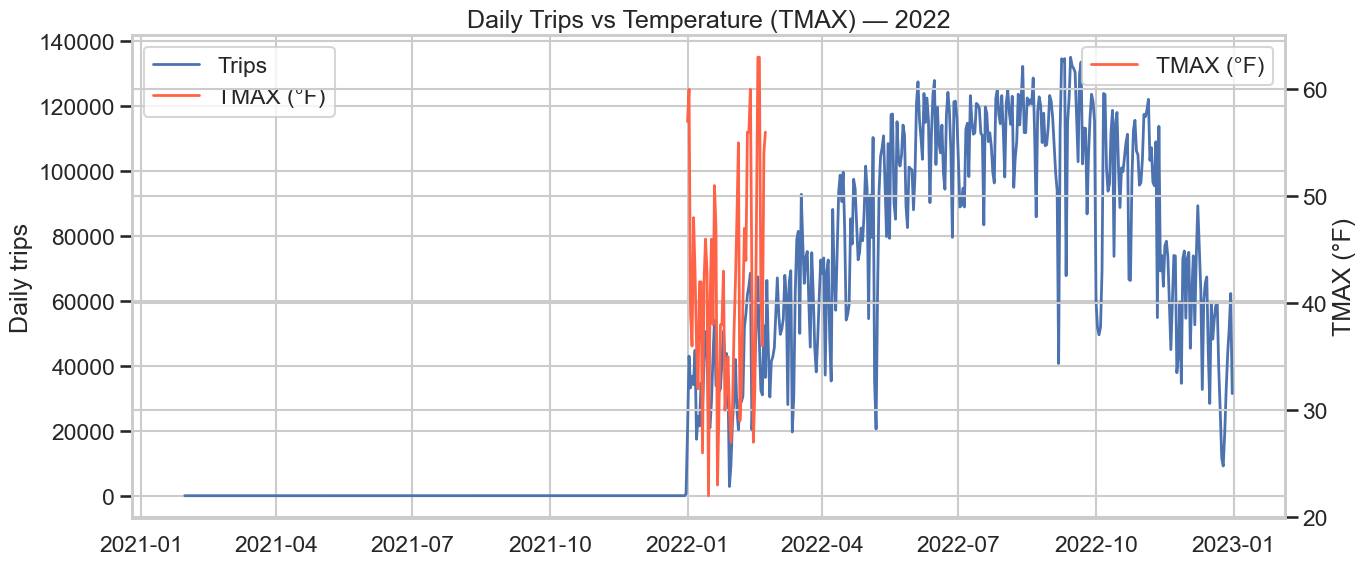

In [16]:
fig, ax1 = plt.subplots(figsize=(14, 6))

# Left axis: trips
sns.lineplot(data=df, x="date", y="trips", ax=ax1, label="Trips", linewidth=2)
ax1.set_ylabel("Daily trips")
ax1.set_xlabel("")
ax1.set_title("Daily Trips vs Temperature (TMAX) — 2022")

# Right axis: temperature
ax2 = ax1.twinx()
sns.lineplot(data=df, x="date", y="TMAX", ax=ax2, color="tomato", label="TMAX (°F)", linewidth=2)
ax2.set_ylabel("TMAX (°F)")

# Combine legends nicely
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc="upper left")

plt.tight_layout()
plt.show()


## Box plot of a categorical variable

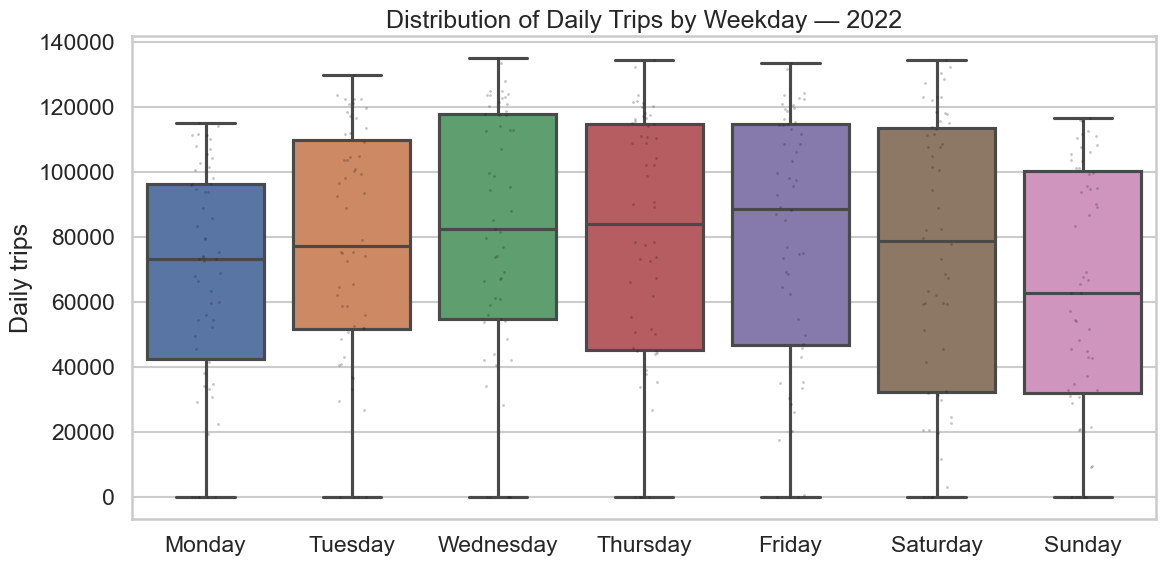

In [19]:
# Derive weekday labels
df["weekday"] = df["date"].dt.day_name()
order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]

plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x="weekday", y="trips", order=order)
sns.stripplot(data=df, x="weekday", y="trips", order=order, alpha=0.25, color="k", size=2)
plt.title("Distribution of Daily Trips by Weekday — 2022")
plt.xlabel("")
plt.ylabel("Daily trips")
plt.tight_layout()
plt.show()


- The box shows the interquartile range (IQR: 25th–75th percentiles), with the line marking the median daily trips.
- Whiskers extend to ~1.5×IQR, and dots beyond that are outliers (unusually high/low days).
- Compare weekday medians to spot the busiest days; often weekends have different distributions than weekdays.

## FacetGrid for deeper insight

/var/folders/pt/j8m6nsxn4_bc4m4ztc59tl380000gp/T/ipykernel_27147/3508548472.py:2: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resulting Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.
  daily_long = pd.melt(
/opt/anaconda3/envs/citibike_2022/lib/python3.10/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  func(*plot_args, **plot_kwargs)
/opt/anaconda3/envs/citibike_2022/lib/python3.10/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  func(*plot_args, **plot_kwargs)
/opt/anaconda3/envs/citibike_2022/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/var/folders/pt/j8m6nsxn4_bc4m4ztc59tl380000gp/

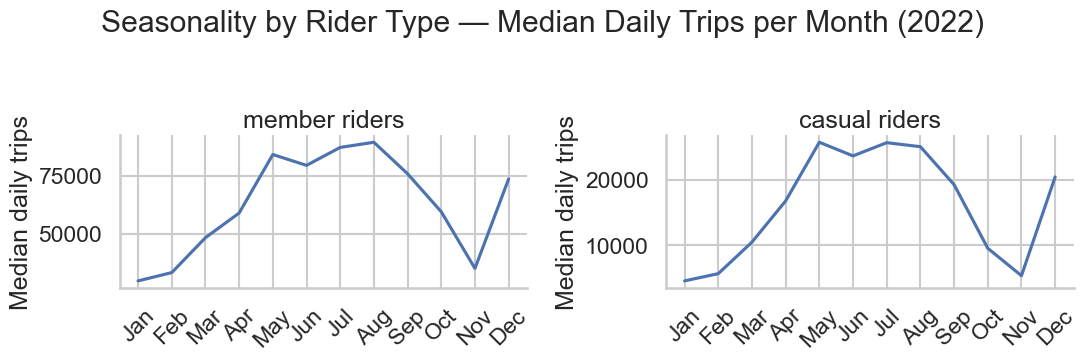

In [23]:
# Long format for member vs casual
daily_long = pd.melt(
    df,
    id_vars=["date"],
    value_vars=["member_trips", "casual_trips"],
    var_name="rider_type",
    value_name="trips"
)

daily_long["rider_type"] = daily_long["rider_type"].str.replace("_trips","", regex=False)
daily_long["month"] = daily_long["date"].dt.strftime("%b")
month_order = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]

g = sns.FacetGrid(
    daily_long, col="rider_type", hue="rider_type",
    sharey=False, height=3.5, aspect=1.6
)
g.map_dataframe(sns.lineplot, x="month", y="trips", estimator="median", ci=None, sort=False,
                color=sns.color_palette("deep")[0])
for ax in g.axes.flatten():
    ax.set_xlabel("")
    ax.set_ylabel("Median daily trips")
    ax.set_xticklabels(month_order, rotation=45)
g.set_titles(col_template="{col_name} riders")
g.fig.suptitle("Seasonality by Rider Type — Median Daily Trips per Month (2022)", y=1.05)
plt.tight_layout()
plt.show()


- The FacetGrid splits the view by rider type, so you can see seasonal patterns side-by-side.
- Typically, casual riders peak more strongly in warm months vs. members (commuters) who are steadier year-round.
- The “median per month” smooths single-day spikes and highlights the overall seasonal shape.

## Monthly/weekly aggregations

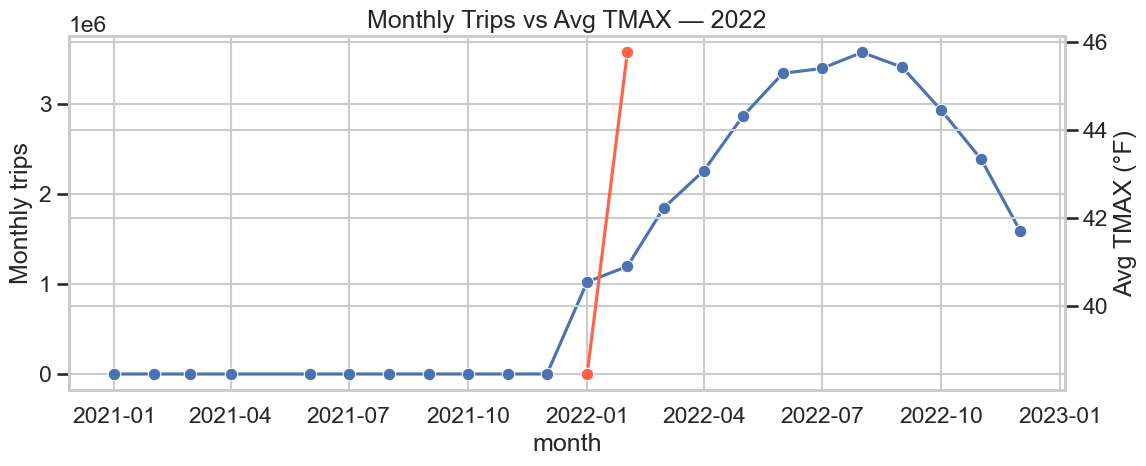

In [28]:
df_month = (df
            .assign(month=df["date"].dt.to_period("M").dt.to_timestamp())
            .groupby("month", as_index=False)
            .agg(trips=("trips","sum"),
                 TMAX=("TMAX","mean")))

fig, ax1 = plt.subplots(figsize=(12,5))
sns.lineplot(data=df_month, x="month", y="trips", ax=ax1, marker="o")
ax1.set_ylabel("Monthly trips")
ax2 = ax1.twinx()
sns.lineplot(data=df_month, x="month", y="TMAX", ax=ax2, color="tomato", marker="o")
ax2.set_ylabel("Avg TMAX (°F)")
ax1.set_title("Monthly Trips vs Avg TMAX — 2022")
plt.tight_layout()
plt.show()
